# Dogs vs Cats - lesson 2

Based on my redux 2, but augmented to visualize some images that we labeled correctly as well as the ones that we labeled incorrectly.

In [1]:
%matplotlib inline

In [2]:
root_path = "data/dogscats-redux/"
weights_path = root_path + 'lesson2_k1_weights.h5'

path = root_path
#path = root_path + "sample/"

results_path = path + 'results/k1/'

A few basic libraries that we'll need for the initial exercises:

In [3]:
from __future__ import division,print_function

import os, json, shutil, random, math
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [11]:
import utils; reload(utils)
from utils import plots, save_array, load_array

In [90]:
def predict_and_show(batches):
    imgs, labels = next(batches)
    preds, indexes, predicted_labels = vgg.predict(imgs)
    true_labels = [vgg.classes[idx] for idx in np.argmax(labels, axis=1)]
    plots(imgs, titles=['ok' if a == b else 'wrong' for (a,b) in zip(true_labels, predicted_labels)])

In [6]:
batch_size=64
import vgg16; reload(vgg16)
vgg = vgg16.Vgg16()

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/1
20000/20000 [==============================] - 1114s - loss: 0.1274 - acc: 0.9666 - val_loss: 0.0649 - val_acc: 0.9824


In [7]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
validation_batches = vgg.get_batches(path+'validation', batch_size=batch_size)
vgg.finetune(batches)
vgg.fit(batches, validation_batches, nb_epoch=1)
vgg.model.save_weights(weights_path)

# Checkpoint

In [ ]:
vgg.model.load_weights(weights_path)

# Try it out
- A few correct labels at random
- A few incorrect labels at random
- The most correct labels of each class
- The most incorrect labels of each class
- The most uncertain labels (those with probabilities near 0.5)

In [15]:
%mkdir -p $results_path

In [9]:
val_batches, val_preds = vgg.test(path+'validation', batch_size=16)

Found 5000 images belonging to 2 classes.


In [32]:
# extract the data that we need for persistence
val_filenames = val_batches.filenames
val_classes = val_batches.classes
del(val_batches)

In [33]:
save_array(results_path+'preds.dat', val_preds)
save_array(results_path+'pred_filenames.dat', val_filenames)
save_array(results_path+'pred_classes.dat', val_classes)

In [34]:
val_preds = load_array(results_path+'preds.dat')
val_filenames = load_array(results_path+'pred_filenames.dat')
val_classes = load_array(results_path+'pred_classes.dat')

In [35]:
val_preds[:5]

array([[  1.0000e+00,   2.0431e-07],
       [  1.0000e+00,   4.4140e-08],
       [  1.0000e+00,   1.3164e-14],
       [  9.9936e-01,   6.3818e-04],
       [  1.0000e+00,   2.6317e-06]], dtype=float32)

In [42]:
val_filenames[0]

'cats/cat.3498.jpg'

convert from one-hot encoding of the class to binary (0=cat, 1=dog)

In [38]:
predicted_labels = np.argmax(val_preds, axis=1)
truth_labels = val_classes

In [68]:
predicted_labels[:5], truth_labels[:5]

(array([0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0], dtype=int32))

In [95]:
def plot_indexes(indexes, filenames, preds, num_show=5):
    from keras.preprocessing import image
    use_indexes = indexes
    np.random.shuffle(use_indexes)
    use_indexes = use_indexes[:num_show]
    filenames_to_show = [os.path.join(path, 'validation', filenames[idx]) for idx in use_indexes]
    imgs = [image.load_img(fname) for fname in filenames_to_show]
    probs = np.max(preds, axis=1)
    plots(imgs, titles=probs[use_indexes], figsize=(24,12))

## some correctly labeled images

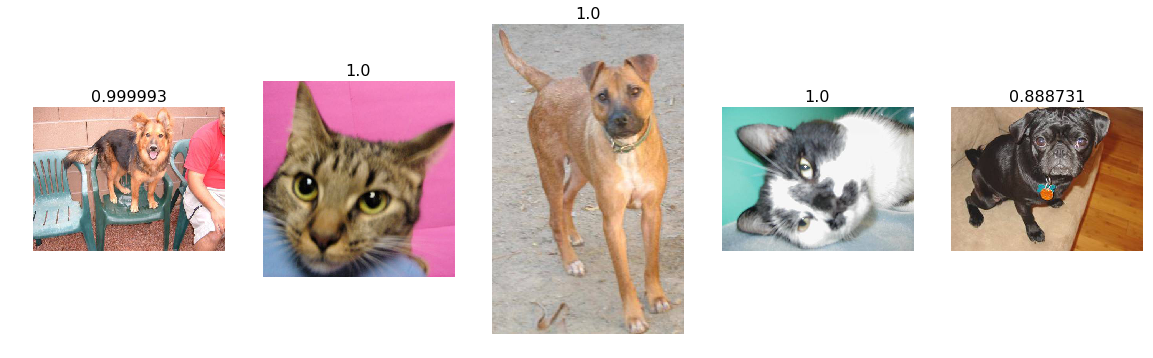

In [96]:
my_indexes = np.where(predicted_labels==truth_labels)[0]
plot_indexes(my_indexes, val_filenames, val_preds)

## some incorrectly labeled images

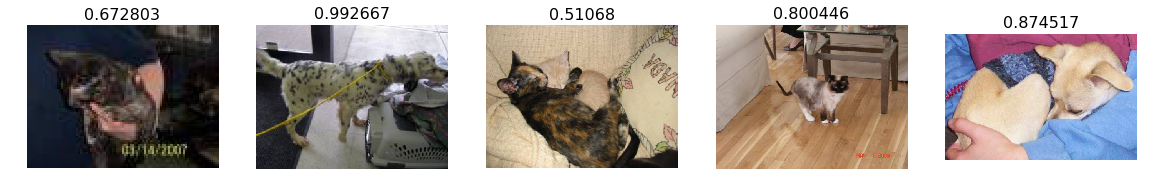

In [97]:
my_indexes = np.where(predicted_labels!=truth_labels)[0]
plot_indexes(my_indexes, val_filenames, val_preds)

## confident that it's a dog, and we were right

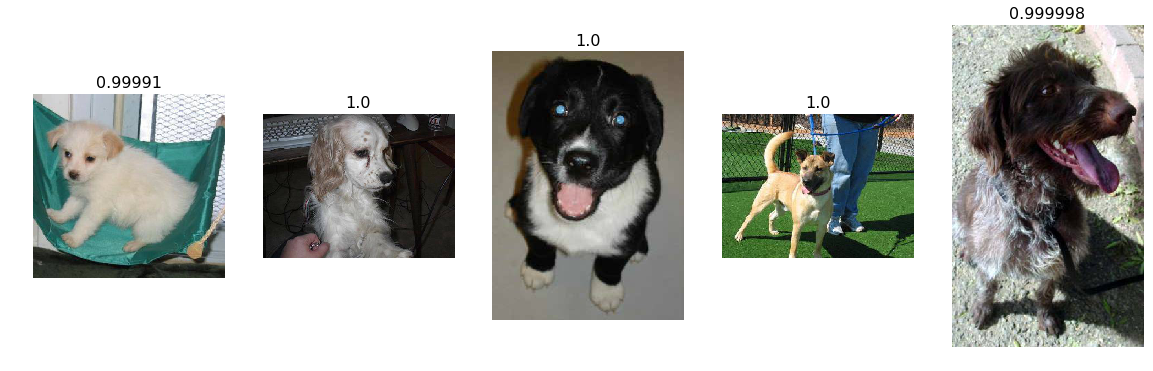

In [98]:
my_indexes = np.where((predicted_labels == 1) & (predicted_labels == truth_labels))[0]
plot_indexes(my_indexes, val_filenames, val_preds)

## confident that it's a dog, and we were wrong

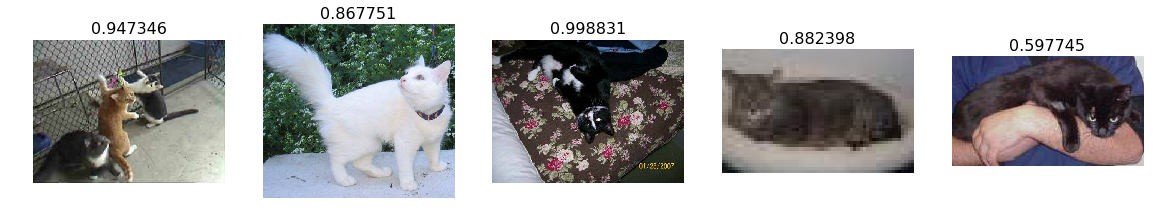

In [99]:
my_indexes = np.where((predicted_labels == 1) & (predicted_labels != truth_labels))[0]
plot_indexes(my_indexes, val_filenames, val_preds)

## confident that it's a cat, and we were right

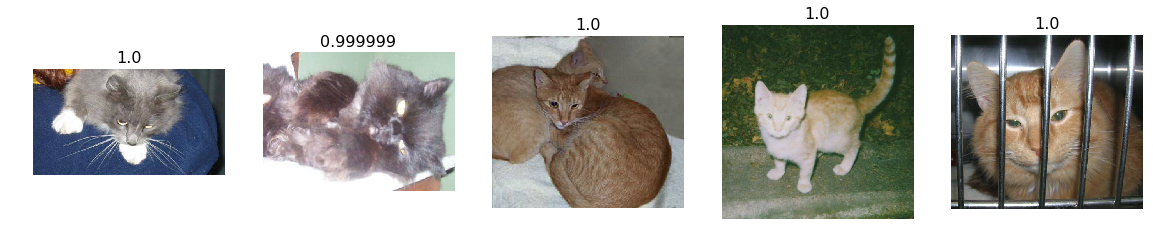

In [100]:
my_indexes = np.where((predicted_labels == 0) & (predicted_labels == truth_labels))[0]
plot_indexes(my_indexes, val_filenames, val_preds)

## confident that it's a cat, and we were wrong

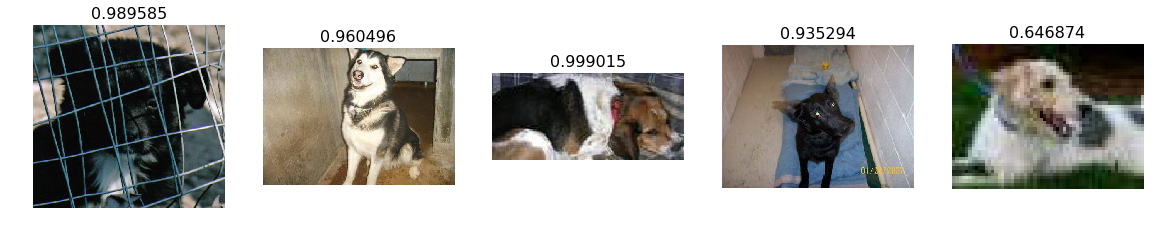

In [101]:
my_indexes = np.where((predicted_labels == 0) & (predicted_labels != truth_labels))[0]
plot_indexes(my_indexes, val_filenames, val_preds)

## dogs that we were unsure about

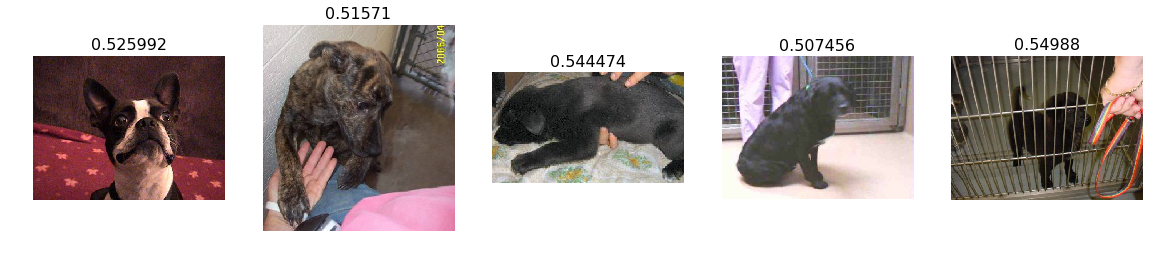

In [102]:
blah = np.max(val_preds, axis=1)
my_indexes = np.where((truth_labels == 1) & (blah > 0.45) & (blah < 0.55))[0]
plot_indexes(my_indexes, val_filenames, val_preds)

## cats that we were unsure about

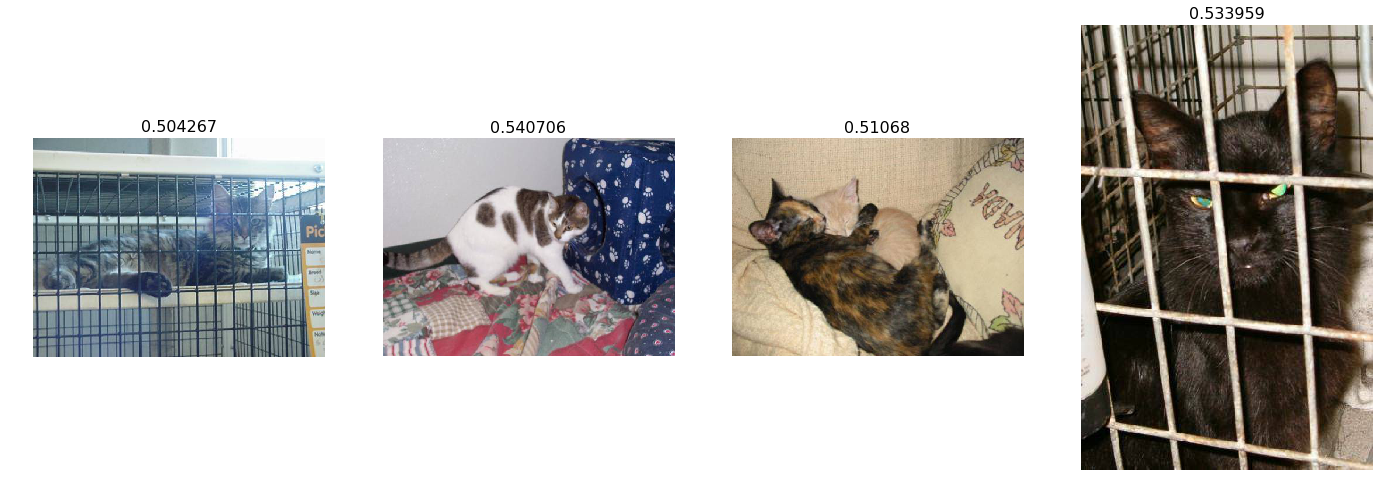

In [103]:
blah = np.max(val_preds, axis=1)
my_indexes = np.where((truth_labels == 0) & (blah > 0.45) & (blah < 0.55))[0]
plot_indexes(my_indexes, val_filenames, val_preds)

# Kaggle Submission

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def get_test_batches(path, batch_size):
    gen = ImageDataGenerator()
    return gen.flow_from_directory(path, target_size=(224,224), class_mode=None, shuffle=False, batch_size=batch_size)

In [ ]:
test_batches = get_test_batches(path + 'test', batch_size=8)

In [ ]:
dog_predictions = vgg.model.predict_generator(test_batches, test_batches.nb_sample)[:,1]
dog_predictions[:5]

Extract the id of each image in the test batch because Keras ImageDataGenerator will enumerate them in lexical order

In [ ]:
ids = [int(x.split("/")[1].split(".")[0]) for x in test_batches.filenames]

fill out the submission table

In [ ]:
with open(root_path + 'keith_submission_2.csv', 'w') as f:
    f.write('id,label\n')
    for i in range(len(ids)):
        f.write('{},{}\n'.format(ids[i], dog_predictions[i]))